Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Train shape: (18154, 21)
Test shape: (4323, 20)


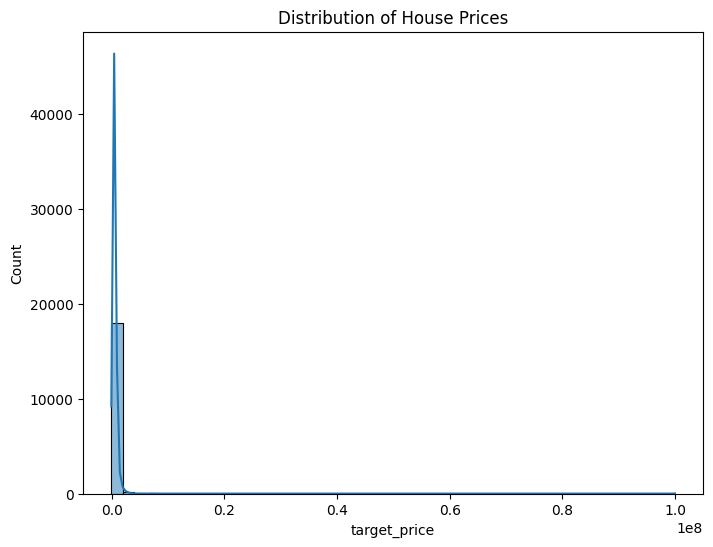

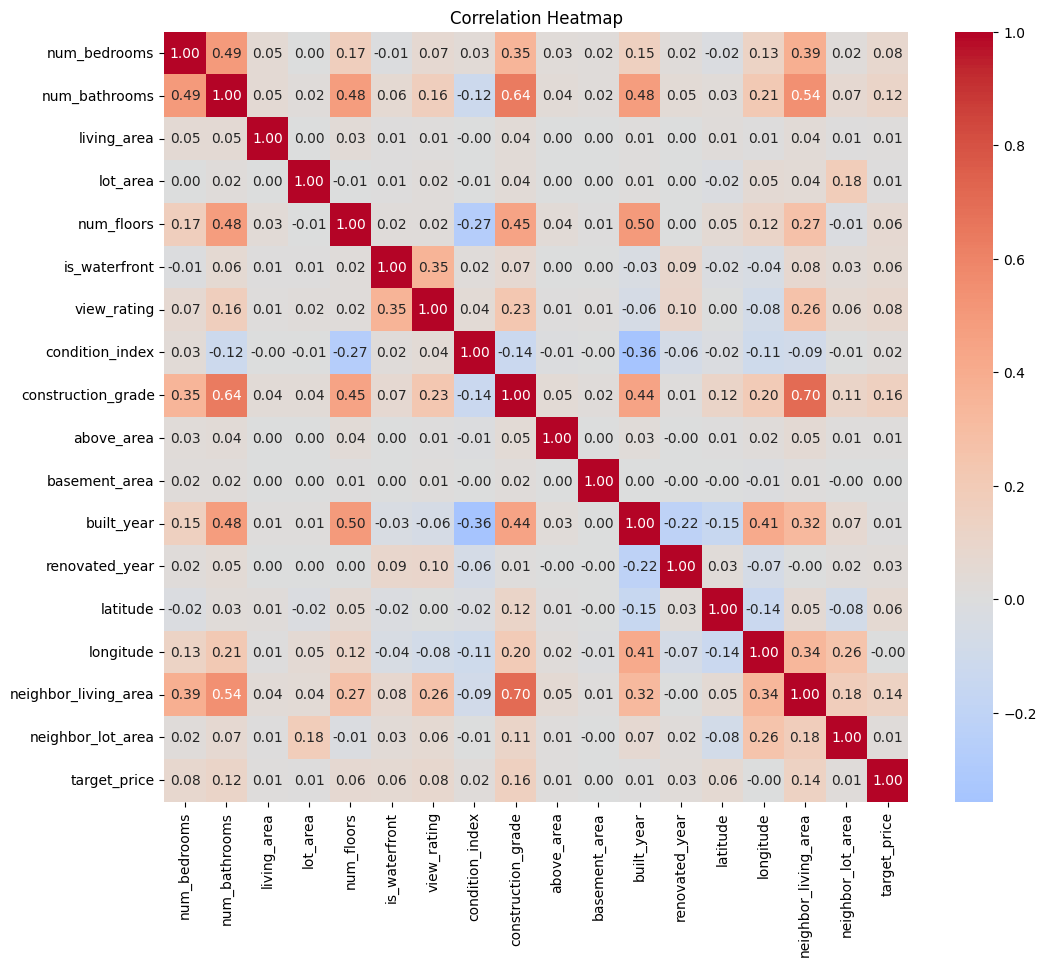

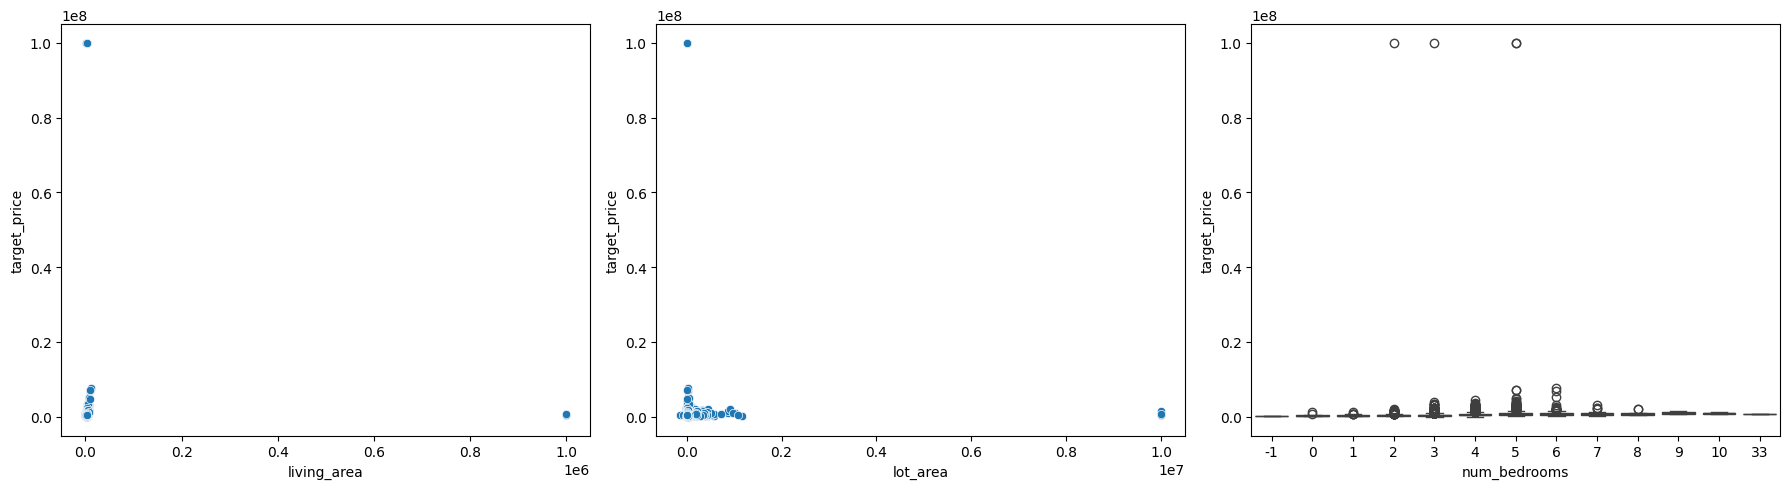

In [ ]:
# ==========================
# Task 02 — House Price Prediction (Random Forest, Gradient Boosting, XGBoost)
# ==========================

!pip install xgboost --quiet

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
import xgboost as xgb

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Helper to load CSV from Google Drive share link
def load_from_gdrive(share_link):
    import re
    file_id = re.search(r"/d/([a-zA-Z0-9_-]+)", share_link).group(1)
    url = f"https://drive.google.com/uc?export=download&id={file_id}"
    df = pd.read_csv(url)
    return df

# ==========================
# 1. Load Data
# ==========================
train_link = "https://drive.google.com/file/d/128XLT44uu9bVSBPd6JiiYyv_M4LJP-3x/view?usp=sharing"
test_link  = "https://drive.google.com/file/d/1JMUa5MIwyx3QEXk3KKt_u0AeMIDUjJUx/view?usp=sharing"

train_df = load_from_gdrive(train_link)
test_df  = load_from_gdrive(test_link)

print("Train shape:", train_df.shape)
print("Test shape:", test_df.shape)

# ==========================
# 2. Data Cleaning / Preprocessing
# ==========================
# Fill missing values
train_df['renovated_year'] = train_df['renovated_year'].fillna(0)
test_df['renovated_year']  = test_df['renovated_year'].fillna(0)

train_df['basement_area'] = train_df['basement_area'].fillna(0)
test_df['basement_area']  = test_df['basement_area'].fillna(0)

# Convert numeric-like columns to float, remove quotes
num_cols = ['num_bedrooms','num_bathrooms','living_area','lot_area','num_floors',
            'is_waterfront','view_rating','condition_index','construction_grade',
            'above_area','basement_area','built_year','renovated_year',
            'neighbor_living_area','neighbor_lot_area']

for col in num_cols:
    train_df[col] = pd.to_numeric(train_df[col], errors='coerce')
    test_df[col]  = pd.to_numeric(test_df[col], errors='coerce')

# Fill any remaining NaN values in numeric columns with median
for col in num_cols:
    train_df[col] = train_df[col].fillna(train_df[col].median())
    test_df[col]  = test_df[col].fillna(train_df[col].median())

# Preserve test house_ids
test_ids = test_df['house_id']

# Drop non-feature columns
train_df = train_df.drop(columns=['house_id','sale_date'])
test_df  = test_df.drop(columns=['house_id','sale_date'])

# Convert zip_area to string (categorical)
train_df['zip_area'] = train_df['zip_area'].astype(str)
test_df['zip_area']  = test_df['zip_area'].astype(str)

# One-hot encode categorical columns (zip_area)
train_df = pd.get_dummies(train_df, columns=['zip_area'], drop_first=True)
test_df  = pd.get_dummies(test_df, columns=['zip_area'], drop_first=True)

# Align train and test columns
train_df, test_df = train_df.align(test_df, join='left', axis=1, fill_value=0)

# ==========================
# 3. Exploratory Data Analysis
# ==========================
plt.figure(figsize=(8,6))
sns.histplot(train_df['target_price'], bins=50, kde=True)
plt.title("Distribution of House Prices")
plt.show()

numeric_cols = train_df.select_dtypes(include=['number'])
plt.figure(figsize=(12,10))
sns.heatmap(numeric_cols.corr(), cmap="coolwarm", center=0, annot=True, fmt=".2f")
plt.title("Correlation Heatmap")
plt.show()

# Scatter / Box plots
fig, axes = plt.subplots(1, 3, figsize=(18,5))
sns.scatterplot(x='living_area', y='target_price', data=train_df, ax=axes[0])
sns.scatterplot(x='lot_area', y='target_price', data=train_df, ax=axes[1])
sns.boxplot(x='num_bedrooms', y='target_price', data=train_df, ax=axes[2])
plt.tight_layout()
plt.show()

# ==========================
# 4. Feature / Target Split
# ==========================
X = train_df.drop(columns=['target_price'])
y = train_df['target_price']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# ==========================
# 5. Model Training & Evaluation
# ==========================
def evaluate_model(model, X_tr, y_tr, X_v, y_v, name):
    model.fit(X_tr, y_tr)
    preds = model.predict(X_v)
    rmse = np.sqrt(mean_squared_error(y_v, preds))
    mae = mean_absolute_error(y_v, preds)
    r2 = r2_score(y_v, preds)
    print(f"{name} → RMSE: {rmse:.2f}, MAE: {mae:.2f}, R²: {r2:.3f}")
    return model, rmse

results = {}

# Random Forest
rf, rmse_rf = evaluate_model(RandomForestRegressor(n_estimators=200, random_state=42, n_jobs=-1),
                             X_train, y_train, X_val, y_val, "Random Forest")
results["Random Forest"] = rmse_rf

# Gradient Boosting
gb, rmse_gb = evaluate_model(GradientBoostingRegressor(n_estimators=300, learning_rate=0.05, max_depth=5, random_state=42),
                             X_train, y_train, X_val, y_val, "Gradient Boosting")
results["Gradient Boosting"] = rmse_gb

# XGBoost
xg, rmse_xg = evaluate_model(xgb.XGBRegressor(n_estimators=500, learning_rate=0.05, max_depth=6,
                                              subsample=0.8, colsample_bytree=0.8, random_state=42),
                             X_train, y_train, X_val, y_val, "XGBoost")
results["XGBoost"] = rmse_xg

print("\nModel RMSE Comparison:", results)

# ==========================
# 6. Final Model & Predictions
# ==========================
best_model_name = min(results, key=results.get)
print("Best Model:", best_model_name)

if best_model_name == "Random Forest":
    final_model = rf
elif best_model_name == "Gradient Boosting":
    final_model = gb
else:
    final_model = xg

# Retrain on full training data
final_model.fit(X, y)
predictions = final_model.predict(test_df)

# ==========================
# 7. Save Submission CSV
# ==========================
submission = pd.DataFrame({
    "house_id": test_ids,
    "predicted_price": predictions.astype(int)
})
submission.to_csv("house_price_predictions.csv", index=False)
print("✅ Saved: house_price_predictions.csv")
submission.head()
